## Anomaly detection using time series classification approach

There are numerous techniques to detect anomalies in time series. Some of them are covered in tutirials for FedotIndustrial framework as far as it is designed solve this sort of task.

In this example we'd like to show you how to solve anomaly detection task using classification approach.

We will use randomly generated time series of univariate and multivariate types with anomaly labels.

This approach rely on construction of classification dataset based of time series and anomaly labels we have. The algorithm is designed so it will crop a time series into samples which are labeled as `anomaly` or `non_anomaly`, and then split this dataset into train and test parts which are ready to be fed into `FedotIndustrial` framework to solve time series classification task.

First, we need to import necessary for this particular example libraries

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from fedot_ind.api.main import FedotIndustrial
from fedot_ind.synth_anomalies.anomaly_generator import AnomalyGenerator
from fedot_ind.core.operation.transformation.splitter import TSSplitter

For this experiment we will use two time series:
- first one is randomly generated time series
- second one is data obtained from real equipment representing power consumption

For this purpose we will define an object of real time series data, obtained from ``.csv`` file, synthetic time series config and desired anomaly config.

It is worth to notice that ``synth_ts`` is a dictionary that may contain different parameters of time series depending on its type. Here are those types and corresponding examples of parameters:

- ``random_walk``: 'start_val': 36.6
- ``sin``: 'amplitude': 10, 'period': 500
- ``auto_regression``: 'ar_params': [0.5, -0.3, 0.2], 'initial_values': [0.5, 0.3, 0.2] or None
- ``smooth_normal``: 'window_size': 300

Anomaly config may contain hyperparameters of different types of anomalies. Every anomaly must be described with the following params:
- ``number`` – quantity of appearances
- ``level`` – anomaly level (the higher the level, the more significant the anomaly)
- ``min_anomaly_length`` – minimum length of anomaly
- ``max_anomaly_length`` – maximum length of anomaly

Additionaly some anomalies may have specific hyperparameters:

- ``noise_type`` – type of noise (``uniform``, ``gaussian`` or ``normal``)
- ``ar_params`` – parameters of autoregression (``List[float]``). Defines the coefficients of the autoregressive model. The number of coefficients determines the order of the autoregressive model.
- ``initial_values`` – initial values of autoregression (``List[float]``). Defines the initial values of the autoregressive model. The number of initial values must be equal to the number of coefficients of the autoregressive model.
- ``start_val`` – start value of random walk (``float``)
- ``amplitude`` – amplitude of sine wave (``float``)
- ``period`` – period of sine wave (``float``)
- ``window_size`` – window size of smooth normal (``int``)

In [14]:
synth_ts = {'ts_type': 'sin',
            'length': 1000,
            'amplitude': 10,
            'period': 500}

MAX_LENGTH = 20
MIN_LENGTH = 10
NUMBER = 10
anomaly_config = {'dip': {'level': 20,
                          'number': NUMBER,
                          'min_anomaly_length': MIN_LENGTH,
                          'max_anomaly_length': MAX_LENGTH},
                  # 'peak': {'level': 20,
                  #          'number': NUMBER,
                  #          'min_anomaly_length': MIN_LENGTH,
                  #          'max_anomaly_length': MAX_LENGTH},
                  # 'shift_trend_up': {'level': 10,
                  #                    'number': NUMBER,
                  #                    'min_anomaly_length': MIN_LENGTH,
                  #                    'max_anomaly_length': MAX_LENGTH},
                  'add_noise': {'level': 80,
                                'number': NUMBER,
                                'noise_type': 'uniform',
                                'min_anomaly_length': MIN_LENGTH,
                                'max_anomaly_length': MAX_LENGTH}
                  }

In [15]:
generator = AnomalyGenerator(config=anomaly_config)

### Synthetic time series

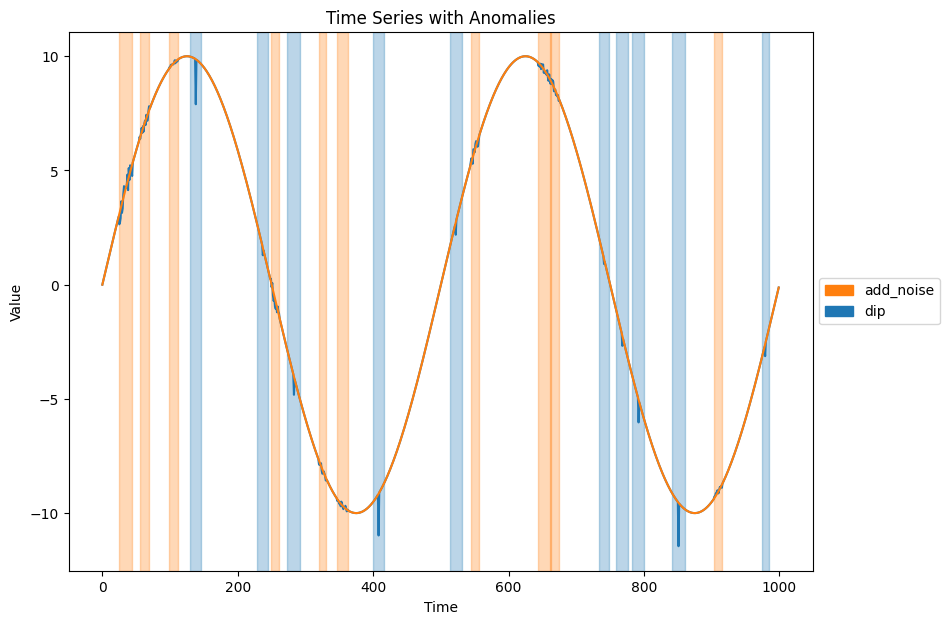

In [16]:
init_synth_ts, mod_synth_ts, synth_inters = generator.generate(time_series_data=synth_ts,
                                                               plot=True,
                                                               overlap=0.1)

Let's take a look at the generated time series and its anomalies more closely:

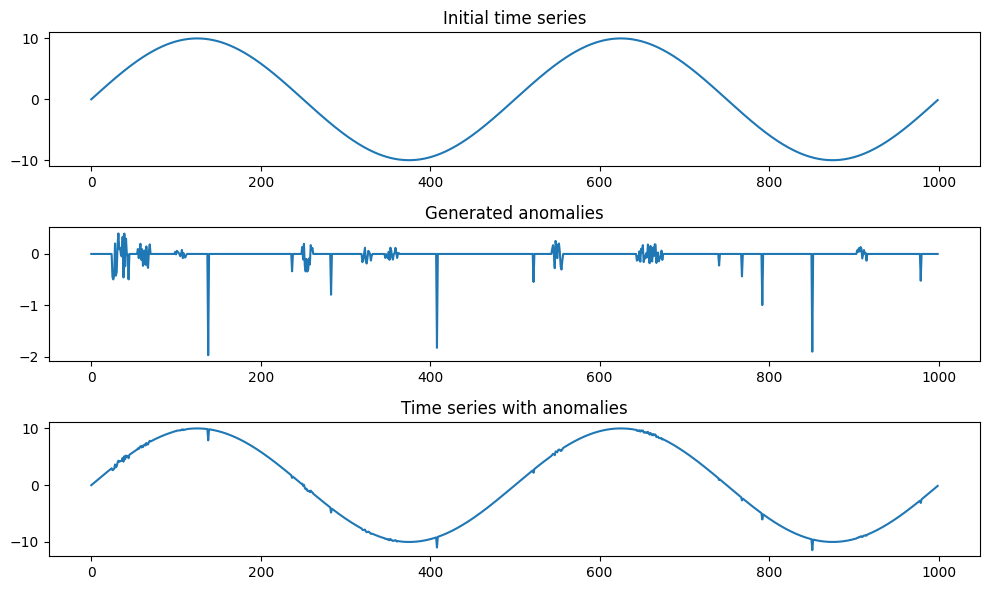

In [17]:
fig, axs = plt.subplots(3, 1, figsize=(10, 6))
axs[0].plot(init_synth_ts)
axs[0].set_title('Initial time series')
axs[1].plot(mod_synth_ts-init_synth_ts)
axs[1].set_title('Generated anomalies')
axs[2].plot(mod_synth_ts)
axs[2].set_title('Time series with anomalies')
plt.tight_layout()
plt.show()

Also, we can take a look at the intervals of anomalies:

In [18]:
synth_inters

{'dip': '733:749, 400:416, 841:860, 758:777, 130:146, 273:292, 229:244, 783:800, 974:984, 513:531',
 'add_noise': '25:44, 544:556, 644:662, 55:69, 99:112, 661:674, 347:363, 320:331, 249:261, 904:915'}

Now, as far as we have time series and anomaly labels, the `TSSplitter` class could be invited to our party. To do it all we need is to instantiate this class with three arguments:

- `time series` (univariate or multivariate in the form `List[time_series]`
- `anomaly_dict` - dictionary with labels of every anomaly class
- `strategy` - the way how dataset is going to formed.

Strategy could be of two types:

- `frequent` - it is when anomaly classes are preserved, but their intervals are transformed to the most frequent length
- `unique` – every combination of anomaly class and particular length are considered as unique anomaly. In this case the output of `split` method will be tuple of three objects: a list of unique anomaly names, list of train subsets and list of test subsets

In [23]:
splitter = TSSplitter(time_series=mod_synth_ts,
                      anomaly_dict=synth_inters,
                      strategy='frequent')

Then we need to call `split` method with two arguments which names are speak for themselfs:

- `plot` tells whether to produce visualisation of initial time series, anomalies and selected non-anomaly intervals
- `binarize` argument could be used in case when there is huge class imbalance and it is more appropriate to combine all anomaly classes into one rather that trying to distinguish them

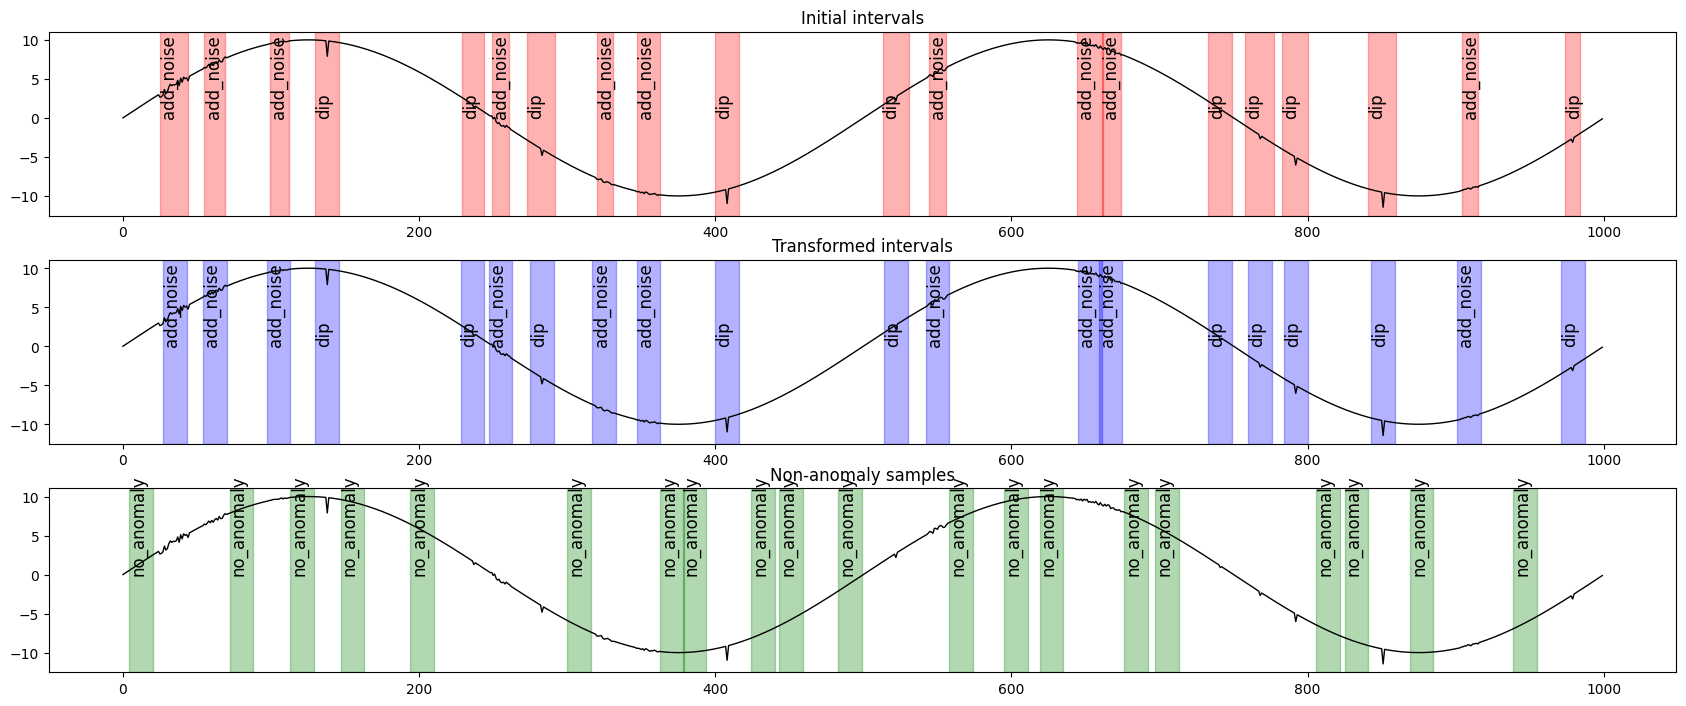

In [24]:
train_data, test_data = splitter.split(plot=True, 
                                       binarize=False)

Now, when our data is ready we can commence to use FedotIndustrial framework in terms of time series classification task.

For this purpose, it is necessary to import the base class FedotIndustrial and determine the parameters of the experiment:

In [25]:
industrial = FedotIndustrial(task='ts_classification',
                             dataset='custom_dataset',
                             strategy='statistical',
                             use_cache=False,
                             timeout=2,
                             n_jobs=2,
                             logging_level=20,
                             output_folder='.')

2023-06-09 16:25:44,561 - Initialising experiment setup
2023-06-09 16:25:44,564 - Experiment setup:
        dataset - custom_dataset,
        strategy - statistical,
        use_cache - False,
        n_jobs - 2,
        timeout - 2
2023-06-09 16:25:44,565 - Initialising solver
2023-06-09 16:25:44,567 - TimeSeriesClassifier initialised


In [26]:
model = industrial.fit(train_features=train_data[0],
                       train_target=train_data[1])

2023-06-09 16:25:45,703 - Fitting model
2023-06-09 16:25:46,058 - AssumptionsHandler - Initial pipeline fitting started
2023-06-09 16:25:47,343 - AssumptionsHandler - Initial pipeline was fitted successfully
2023-06-09 16:25:47,345 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 0.2 MiB, max: 0.6 MiB
2023-06-09 16:25:47,348 - ApiComposer - Initial pipeline was fitted in 1.3 sec.
2023-06-09 16:25:47,350 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2023-06-09 16:25:47,363 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 2 min. Set of candidate models: ['logit', 'scaling', 'lgbm', 'dt', 'knn', 'normalization', 'resample', 'mlp', 'pca', 'fast_ica', 'poly_features', 'bernb', 'rf', 'qda', 'isolation_forest_class', 'logit', 'scaling', 'lgbm', 'dt', 'knn', 'normalization', 'resample', 'mlp', 'pca', 'fast_ica', 'poly_features', 'bernb', 'rf', 'qda', 'isolation

Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2023-06-09 16:25:47,377 - MultiprocessingDispatcher - Number of used CPU's: 2
2023-06-09 16:25:48,151 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-06-09 16:25:48,155 - EvoGraphOptimizer - Generation num: 1 size: 1
2023-06-09 16:25:48,157 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.863 ComplexityMetricsEnum.node_num=0.200>']
2023-06-09 16:25:50,412 - MultiprocessingDispatcher - Number of used CPU's: 2
2023-06-09 16:25:55,782 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-06-09 16:25:55,785 - EvoGraphOptimizer - Generation num: 2 size: 21
2023-06-09 16:25:55,787 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.899 ComplexityMetricsEnum.node_num=0.300>']
2023-06-09 16:25:55,791 - EvoGraphOptimizer - Next population siz

Generations:   0%|          | 1/10000 [01:11<?, ?gen/s]

2023-06-09 16:26:58,996 - OptimisationTimer - Composition time: 1.194 min
2023-06-09 16:26:58,999 - OptimisationTimer - Algorithm was terminated due to processing time limit
2023-06-09 16:26:59,003 - EvoGraphOptimizer - Generation num: 10 size: 1
2023-06-09 16:26:59,005 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.944 ComplexityMetricsEnum.node_num=0.100>']
2023-06-09 16:26:59,007 - EvoGraphOptimizer - no improvements for 4 iterations
2023-06-09 16:26:59,010 - EvoGraphOptimizer - spent time: 1.2 min
2023-06-09 16:26:59,015 - GPComposer - GP composition finished
2023-06-09 16:26:59,019 - DataSourceSplitter - K-folds cross validation is applied.
2023-06-09 16:26:59,022 - ApiComposer - Hyperparameters tuning started with 1 min. timeout
2023-06-09 16:26:59,025 - SimultaneousTuner - Hyperparameters optimization start: estimation of metric for initial pipeline


2023-06-09 16:27:00,526 - SimultaneousTuner - Initial graph: {'depth': 1, 'length': 1, 'nodes': [rf]}
rf - {'n_jobs': 1, 'criterion': 'entropy', 'max_features': 0.6953315293977174, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': False} 
Initial metric: 0.947
  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]2023-06-09 16:27:00,555 - build_posterior_wrapper took 0.010386 seconds
2023-06-09 16:27:00,557 - TPE using 0 trials
  0%|          | 1/100000 [00:00<?, ?trial/s, best loss=?]2023-06-09 16:27:02,161 - build_posterior_wrapper took 0.010732 seconds
2023-06-09 16:27:02,165 - TPE using 1/1 trials with best loss -0.947368
  0%|          | 2/100000 [00:02<64:23:49,  2.32s/trial, best loss: -0.947368]2023-06-09 16:27:04,480 - build_posterior_wrapper took 0.010379 seconds
2023-06-09 16:27:04,483 - TPE using 2/2 trials with best loss -0.947368
  0%|          | 3/100000 [00:04<64:21:02,  2.32s/trial, best loss: -0.947368]2023-06-09 16:27:06,799 - build_posterior_wrapper took 0.

{'depth': 1, 'length': 1, 'nodes': [rf]}


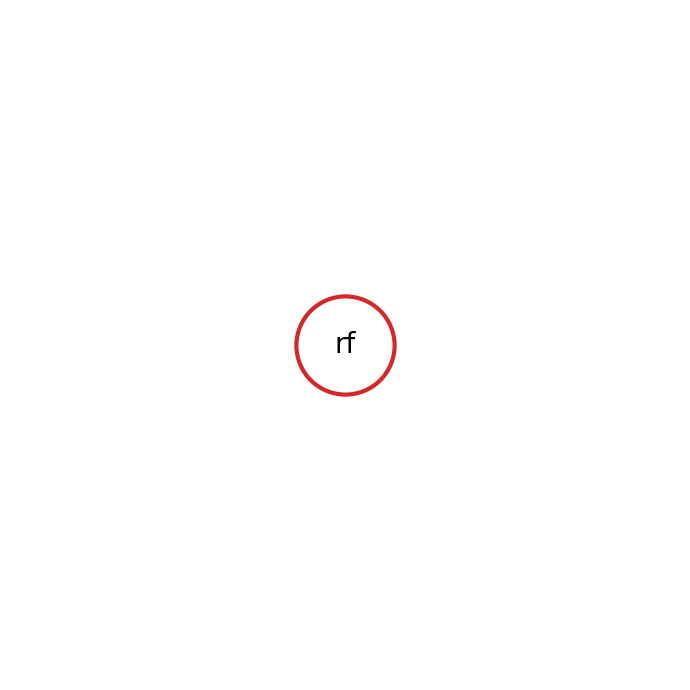

In [27]:
print(model.current_pipeline)

model.current_pipeline.show(node_size_scale=1)

In [28]:
labels = industrial.predict(test_features=test_data[0],
                            test_target=test_data[1])

probs = industrial.predict_proba(test_features=test_data[0],
                                 test_target=test_data[1])

print(labels.ravel()), print(test_data[1])

2023-06-09 16:28:36,871 - Predicting with statistical generator
2023-06-09 16:28:36,971 - Predicting with statistical generator
['no_anomaly' 'no_anomaly' 'add_noise' 'dip' 'add_noise' 'no_anomaly'
 'dip' 'no_anomaly']
['no_anomaly', 'no_anomaly', 'add_noise', 'dip', 'add_noise', 'no_anomaly', 'dip', 'no_anomaly']


(None, None)

In [29]:
from sklearn.metrics import classification_report

print(classification_report(test_data[1], labels))

              precision    recall  f1-score   support

   add_noise       1.00      1.00      1.00         2
         dip       1.00      1.00      1.00         2
  no_anomaly       1.00      1.00      1.00         4

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



### Real time series

In [71]:
data = pd.read_csv('power.csv', index_col=0)['Power']
real_time_series = data.values

MAX_LENGTH = 15
MIN_LENGTH = 10
NUMBER = 6
anomaly_config_real_ts = {'dip': {'level': 1,
                          'number': 8,
                          'min_anomaly_length': 13,
                          'max_anomaly_length': 13},
                  # 'peak': {'level': 20,
                  #          'number': NUMBER,
                  #          'min_anomaly_length': MIN_LENGTH,
                  #          'max_anomaly_length': MAX_LENGTH},
                  'shift_trend_up': {'level': 2,
                                     'number': 6,
                                     'min_anomaly_length': 10,
                                     'max_anomaly_length': 10},
                  # 'add_noise': {'level': 80,
                  #               'number': NUMBER,
                  #               'noise_type': 'uniform',
                  #               'min_anomaly_length': MIN_LENGTH,
                  #               'max_anomaly_length': MAX_LENGTH}
                  }

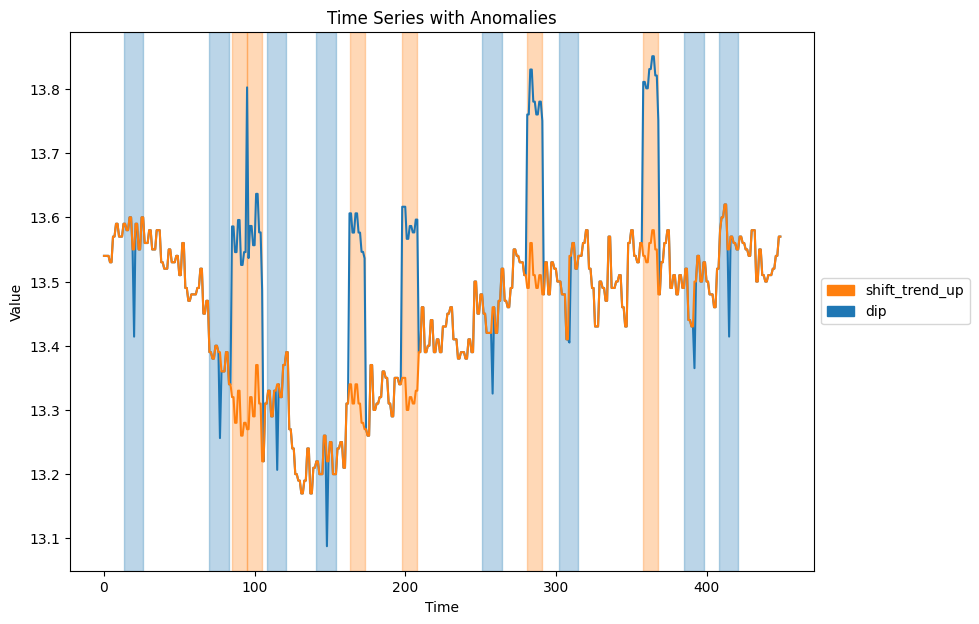

In [72]:
generator_real_ts = AnomalyGenerator(config=anomaly_config_real_ts)
init_real_ts, mod_real_ts, real_inters = generator_real_ts.generate(time_series_data=real_time_series,
                                                                    plot=True,
                                                                    overlap=0)

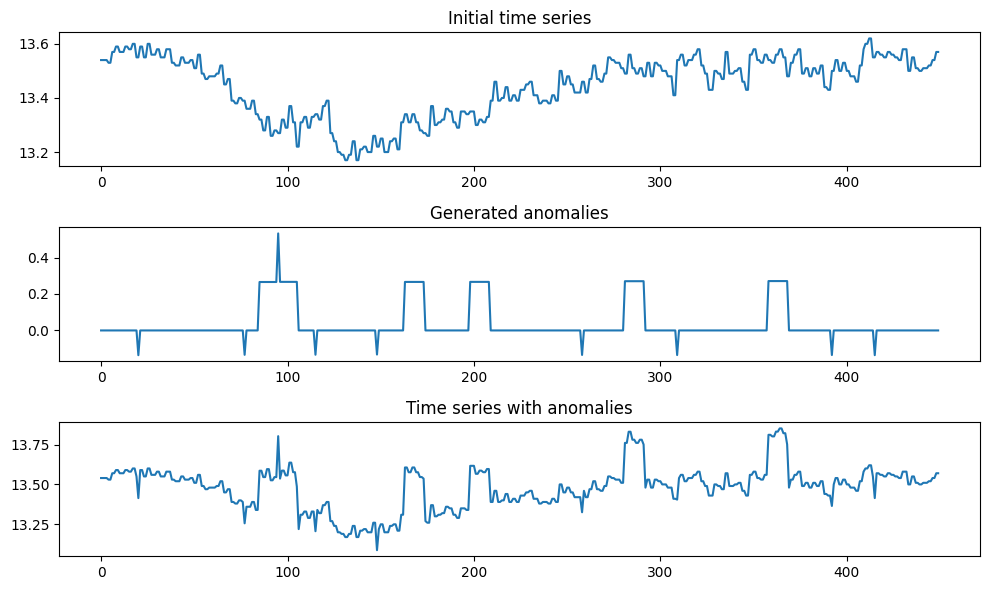

In [73]:
fig, axs = plt.subplots(3, 1, figsize=(10, 6))
axs[0].plot(init_real_ts)
axs[0].set_title('Initial time series')
axs[1].plot(mod_real_ts-init_real_ts)
axs[1].set_title('Generated anomalies')
axs[2].plot(mod_real_ts)
axs[2].set_title('Time series with anomalies')
plt.tight_layout()
plt.show()

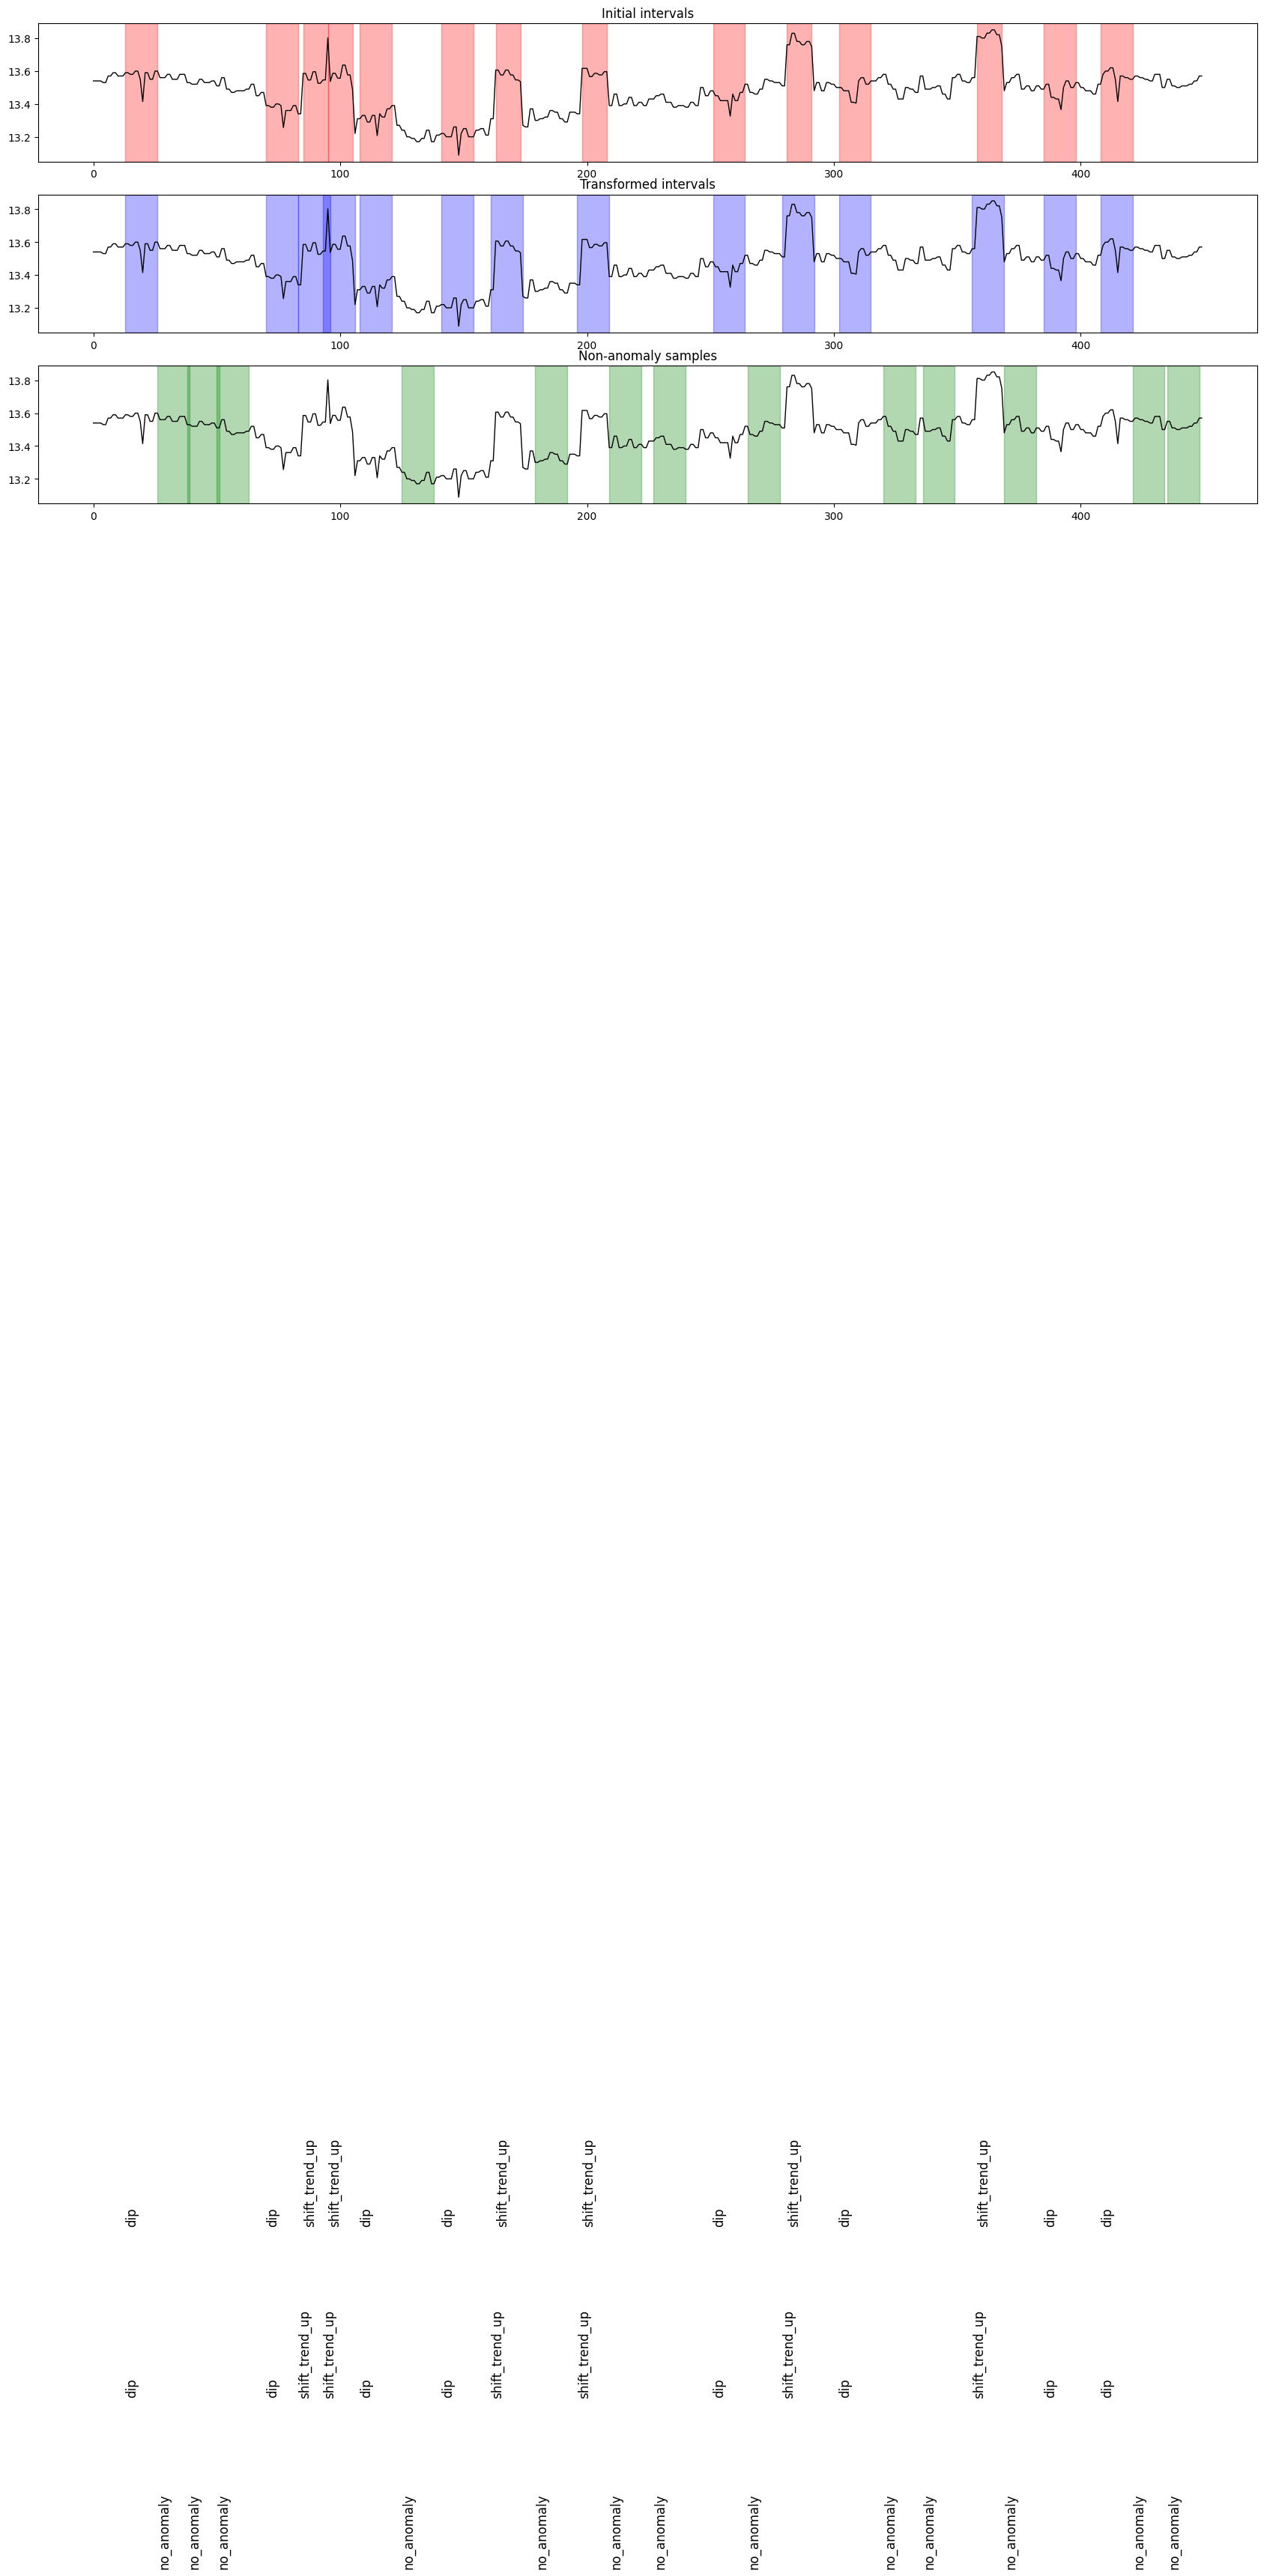

In [74]:
splitter_real = TSSplitter(time_series=mod_real_ts,
                      anomaly_dict=real_inters,
                      strategy='frequent')
train_data_real, test_data_real = splitter_real.split(plot=True,
                                       binarize=False)

In [75]:
industrial_real = FedotIndustrial(task='ts_classification',
                             dataset='custom_dataset',
                             strategy='statistical',
                             use_cache=False,
                             timeout=2,
                             n_jobs=2,
                             logging_level=20,
                             output_folder='.')

model_real = industrial_real.fit(train_features=train_data_real[0],
                       train_target=train_data_real[1])

2023-06-09 16:53:19,888 - Initialising experiment setup
2023-06-09 16:53:19,892 - Experiment setup:
        dataset - custom_dataset,
        strategy - statistical,
        use_cache - False,
        n_jobs - 2,
        timeout - 2
2023-06-09 16:53:19,893 - Initialising solver
2023-06-09 16:53:19,895 - TimeSeriesClassifier initialised
2023-06-09 16:53:19,897 - Fitting model
2023-06-09 16:53:20,635 - AssumptionsHandler - Initial pipeline fitting started
2023-06-09 16:53:22,002 - AssumptionsHandler - Initial pipeline was fitted successfully
2023-06-09 16:53:22,004 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 0.2 MiB, max: 0.6 MiB
2023-06-09 16:53:22,006 - ApiComposer - Initial pipeline was fitted in 1.4 sec.
2023-06-09 16:53:22,009 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2023-06-09 16:53:22,021 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 2

Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2023-06-09 16:53:22,035 - MultiprocessingDispatcher - Number of used CPU's: 2
2023-06-09 16:53:22,684 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-06-09 16:53:22,688 - EvoGraphOptimizer - Generation num: 1 size: 1
2023-06-09 16:53:22,691 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.982 ComplexityMetricsEnum.node_num=0.200>']
2023-06-09 16:53:25,588 - MultiprocessingDispatcher - Number of used CPU's: 2
2023-06-09 16:53:30,831 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-06-09 16:53:30,833 - EvoGraphOptimizer - Generation num: 2 size: 21
2023-06-09 16:53:30,836 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.982 ComplexityMetricsEnum.node_num=0.200>']
2023-06-09 16:53:30,839 - EvoGraphOptimizer - no improvements for

Generations:   0%|          | 1/10000 [00:48<?, ?gen/s]

2023-06-09 16:54:10,789 - OptimisationTimer - Composition time: 0.813 min
2023-06-09 16:54:10,792 - EvoGraphOptimizer - Generation num: 7 size: 1
2023-06-09 16:54:10,795 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.982 ComplexityMetricsEnum.node_num=0.200>']
2023-06-09 16:54:10,797 - EvoGraphOptimizer - no improvements for 6 iterations
2023-06-09 16:54:10,800 - EvoGraphOptimizer - spent time: 0.8 min
2023-06-09 16:54:10,804 - GPComposer - GP composition finished
2023-06-09 16:54:10,808 - DataSourceSplitter - K-folds cross validation is applied.
2023-06-09 16:54:10,812 - ApiComposer - Hyperparameters tuning started with 1 min. timeout
2023-06-09 16:54:10,816 - SimultaneousTuner - Hyperparameters optimization start: estimation of metric for initial pipeline


2023-06-09 16:54:13,037 - SimultaneousTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [rf, scaling]}
rf - {'n_jobs': 1}
scaling - {} 
Initial metric: 0.962
  0%|          | 0/100000 [00:00<?, ?trial/s, best loss=?]2023-06-09 16:54:13,065 - build_posterior_wrapper took 0.010394 seconds
2023-06-09 16:54:13,067 - TPE using 0 trials
  0%|          | 1/100000 [00:02<64:49:33,  2.33s/trial, best loss: -0.499]2023-06-09 16:54:15,400 - build_posterior_wrapper took 0.010276 seconds
2023-06-09 16:54:15,403 - TPE using 1/1 trials with best loss -0.499000
  0%|          | 2/100000 [00:03<52:10:25,  1.88s/trial, best loss: -0.499]2023-06-09 16:54:16,961 - build_posterior_wrapper took 0.011507 seconds
2023-06-09 16:54:16,963 - TPE using 2/2 trials with best loss -0.499000
  0%|          | 3/100000 [00:06<57:32:55,  2.07s/trial, best loss: -0.499]2023-06-09 16:54:19,262 - build_posterior_wrapper took 0.009982 seconds
2023-06-09 16:54:19,264 - TPE using 3/3 trials with best loss -0.499000
  

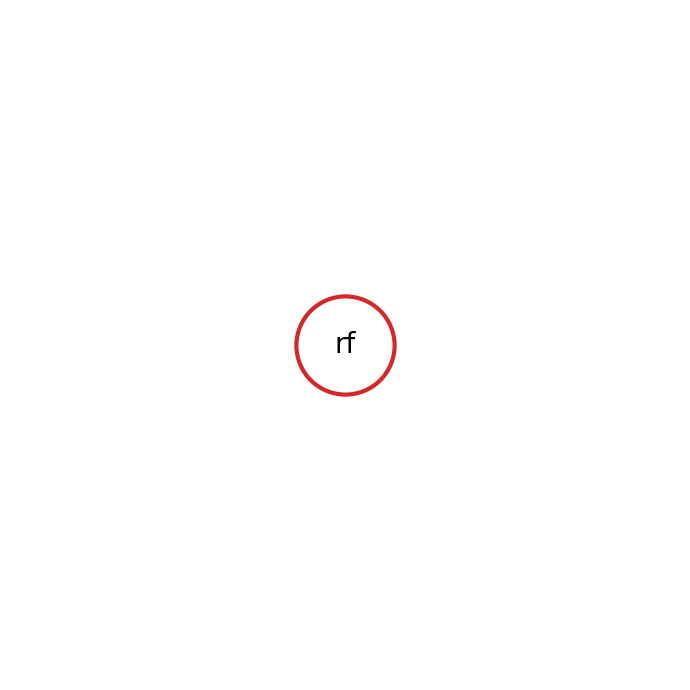

In [76]:
model.current_pipeline.show(node_size_scale=1)

In [77]:
labels_real = industrial_real.predict(test_features=test_data_real[0],
                            test_target=test_data_real[1])

probs_real = industrial_real.predict_proba(test_features=test_data_real[0],
                                 test_target=test_data_real[1])

2023-06-09 16:55:21,890 - Predicting with statistical generator
2023-06-09 16:55:21,966 - Predicting with statistical generator


In [78]:
print(labels_real.ravel()), print(test_data_real[1])

['no_anomaly' 'no_anomaly' 'dip' 'shift_trend_up' 'dip' 'no_anomaly']
['no_anomaly', 'no_anomaly', 'dip', 'shift_trend_up', 'dip', 'no_anomaly']


(None, None)

In [79]:
print(classification_report(test_data_real[1], labels_real))

                precision    recall  f1-score   support

           dip       1.00      1.00      1.00         2
    no_anomaly       1.00      1.00      1.00         3
shift_trend_up       1.00      1.00      1.00         1

      accuracy                           1.00         6
     macro avg       1.00      1.00      1.00         6
  weighted avg       1.00      1.00      1.00         6



### Real time series with noise

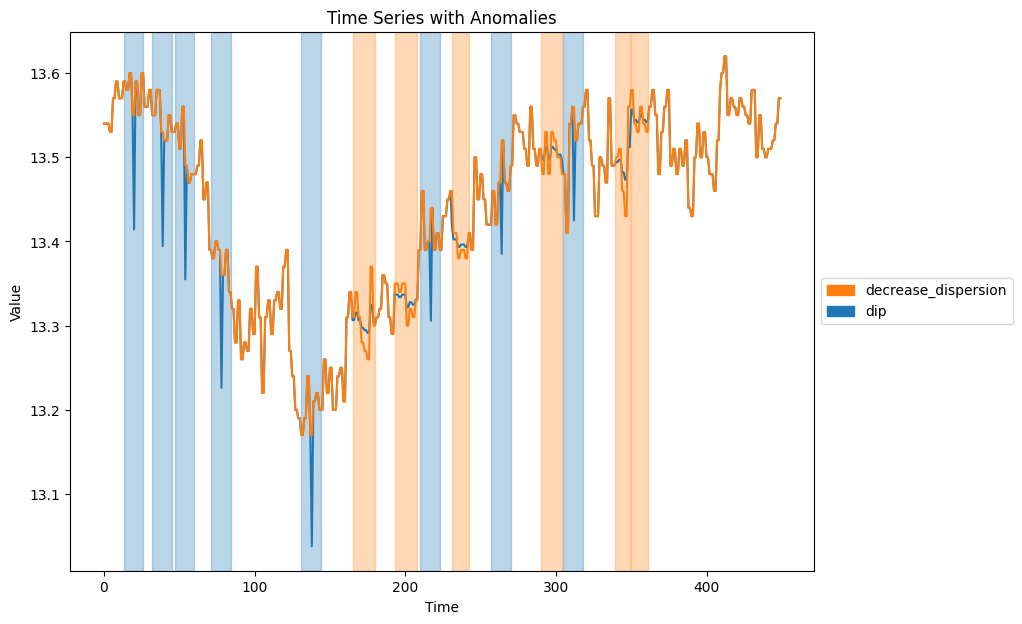

In [87]:
data = pd.read_csv('power.csv', index_col=0)['Power']
real_time_series = data.values

# MAX_LENGTH = 15
# MIN_LENGTH = 10
# NUMBER = 6
anomaly_config_real_ts = {'dip': {'level': 1,
                          'number': 8,
                          'min_anomaly_length': 13,
                          'max_anomaly_length': 13},
                  # 'peak': {'level': 20,
                  #          'number': NUMBER,
                  #          'min_anomaly_length': MIN_LENGTH,
                  #          'max_anomaly_length': MAX_LENGTH},
                  # 'shift_trend_up': {'level': 2,
                  #                    'number': 6,
                  #                    'min_anomaly_length': 10,
                  #                    'max_anomaly_length': 10},
                  'decrease_dispersion': {'level': 70,
                                                'number': 6,
                                                'min_anomaly_length': 10,
                                                'max_anomaly_length': 15},
                  }

generator_real_ts = AnomalyGenerator(config=anomaly_config_real_ts)
init_real_ts, mod_real_ts, real_inters = generator_real_ts.generate(time_series_data=real_time_series,
                                                                    plot=True,
                                                                    overlap=0)

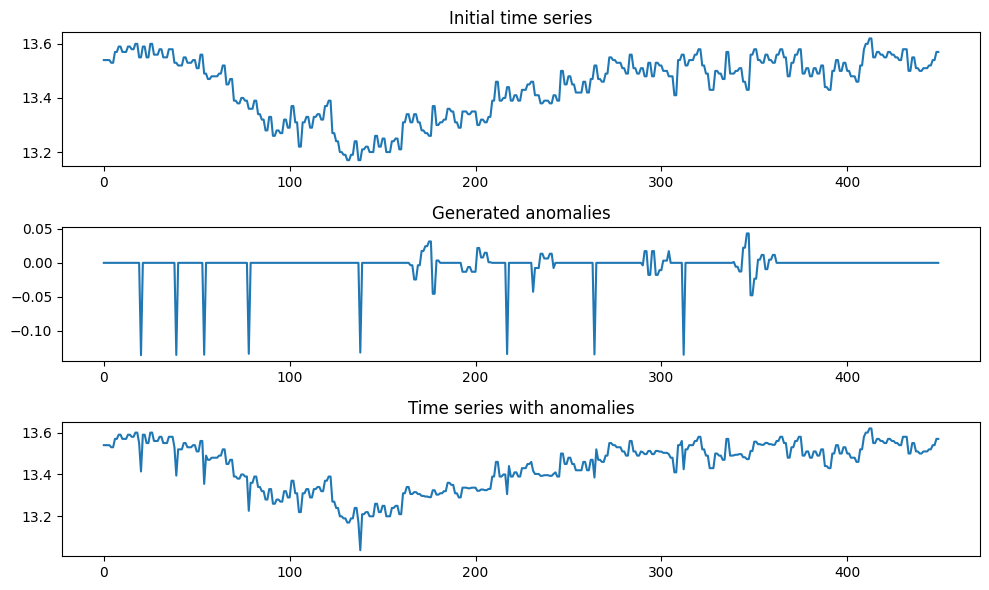

In [88]:
fig, axs = plt.subplots(3, 1, figsize=(10, 6))
axs[0].plot(init_real_ts)
axs[0].set_title('Initial time series')
axs[1].plot(mod_real_ts-init_real_ts)
axs[1].set_title('Generated anomalies')
axs[2].plot(mod_real_ts)
axs[2].set_title('Time series with anomalies')
plt.tight_layout()
plt.show()

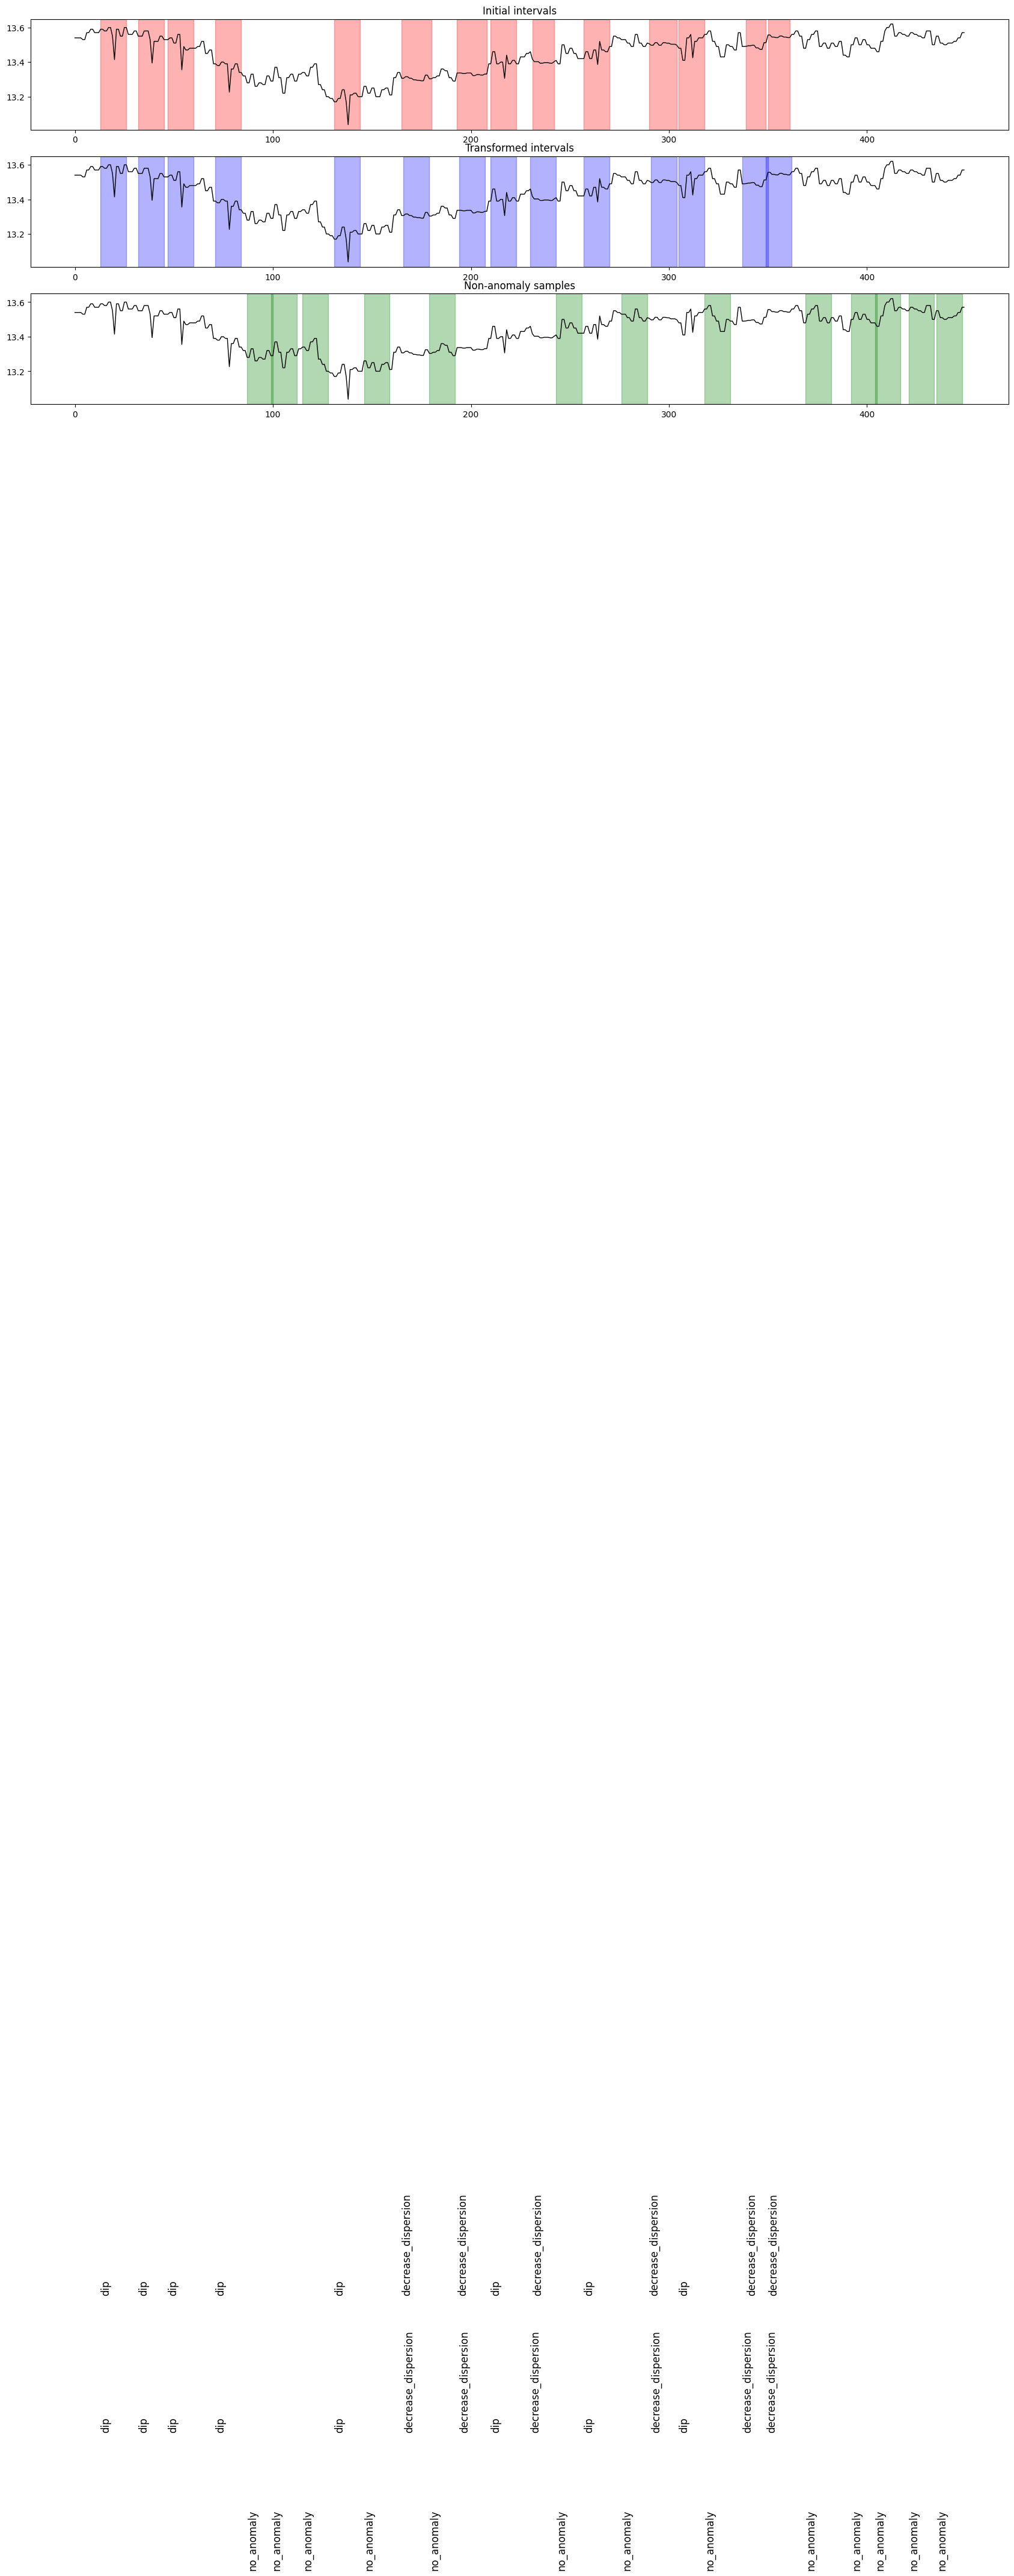

In [89]:
splitter_real = TSSplitter(time_series=mod_real_ts,
                      anomaly_dict=real_inters,
                      strategy='frequent')
train_data_real, test_data_real = splitter_real.split(plot=True,
                                       binarize=False)

In [90]:
industrial_real = FedotIndustrial(task='ts_classification',
                             dataset='custom_dataset',
                             strategy='statistical',
                             use_cache=False,
                             timeout=2,
                             n_jobs=2,
                             logging_level=20,
                             output_folder='.')

model_real = industrial_real.fit(train_features=train_data_real[0],
                       train_target=train_data_real[1])

2023-06-09 17:02:13,270 - Initialising experiment setup
2023-06-09 17:02:13,272 - Experiment setup:
        dataset - custom_dataset,
        strategy - statistical,
        use_cache - False,
        n_jobs - 2,
        timeout - 2
2023-06-09 17:02:13,273 - Initialising solver
2023-06-09 17:02:13,274 - TimeSeriesClassifier initialised
2023-06-09 17:02:13,276 - Fitting model
2023-06-09 17:02:13,704 - AssumptionsHandler - Initial pipeline fitting started
2023-06-09 17:02:15,073 - AssumptionsHandler - Initial pipeline was fitted successfully
2023-06-09 17:02:15,075 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 0.2 MiB, max: 0.6 MiB
2023-06-09 17:02:15,077 - ApiComposer - Initial pipeline was fitted in 1.4 sec.
2023-06-09 17:02:15,079 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2023-06-09 17:02:15,092 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 2

Generations:   0%|          | 1/10000 [00:00<?, ?gen/s]

2023-06-09 17:02:15,105 - MultiprocessingDispatcher - Number of used CPU's: 2
2023-06-09 17:02:22,714 - MultiprocessingDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2023-06-09 17:02:22,721 - EvoGraphOptimizer - Generation num: 1 size: 1
2023-06-09 17:02:22,725 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.894 ComplexityMetricsEnum.node_num=0.200>']
2023-06-09 17:02:25,176 - MultiprocessingDispatcher - Number of used CPU's: 2
2023-06-09 17:02:34,627 - MultiprocessingDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2023-06-09 17:02:34,632 - EvoGraphOptimizer - Generation num: 2 size: 21
2023-06-09 17:02:34,634 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.941 ComplexityMetricsEnum.node_num=0.200>']
2023-06-09 17:02:34,636 - EvoGraphOptimizer - Next population siz

Generations:   0%|          | 1/10000 [01:04<?, ?gen/s]

2023-06-09 17:03:19,912 - OptimisationTimer - Composition time: 1.08 min
2023-06-09 17:03:19,914 - OptimisationTimer - Algorithm was terminated due to processing time limit
2023-06-09 17:03:19,917 - EvoGraphOptimizer - Generation num: 9 size: 1
2023-06-09 17:03:19,919 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<ClassificationMetricsEnum.ROCAUC_penalty=-0.989 ComplexityMetricsEnum.node_num=0.200>']
2023-06-09 17:03:19,921 - EvoGraphOptimizer - no improvements for 5 iterations
2023-06-09 17:03:19,923 - EvoGraphOptimizer - spent time: 1.1 min
2023-06-09 17:03:19,930 - GPComposer - GP composition finished
2023-06-09 17:03:19,934 - DataSourceSplitter - K-folds cross validation is applied.
2023-06-09 17:03:19,936 - ApiComposer - Hyperparameters tuning started with 1 min. timeout
2023-06-09 17:03:19,940 - SimultaneousTuner - Hyperparameters optimization start: estimation of metric for initial pipeline


2023-06-09 17:03:20,148 - SimultaneousTuner - Initial graph: {'depth': 2, 'length': 2, 'nodes': [logit, poly_features]}
logit - {}
poly_features - {} 
Initial metric: 0.992
  0%|          | 0/100000 [00:00<?, ?trial/s, best loss=?]2023-06-09 17:03:20,169 - build_posterior_wrapper took 0.007461 seconds
2023-06-09 17:03:20,171 - TPE using 0 trials
  0%|          | 1/100000 [00:00<6:53:55,  4.03trial/s, best loss: -0.977042]2023-06-09 17:03:20,418 - build_posterior_wrapper took 0.006309 seconds
2023-06-09 17:03:20,420 - TPE using 1/1 trials with best loss -0.977042
  0%|          | 2/100000 [00:00<6:11:35,  4.49trial/s, best loss: -0.992012]2023-06-09 17:03:20,624 - build_posterior_wrapper took 0.006753 seconds
2023-06-09 17:03:20,627 - TPE using 2/2 trials with best loss -0.992012
  0%|          | 3/100000 [00:00<6:25:46,  4.32trial/s, best loss: -0.992012]2023-06-09 17:03:20,867 - build_posterior_wrapper took 0.007797 seconds
2023-06-09 17:03:20,870 - TPE using 3/3 trials with best loss

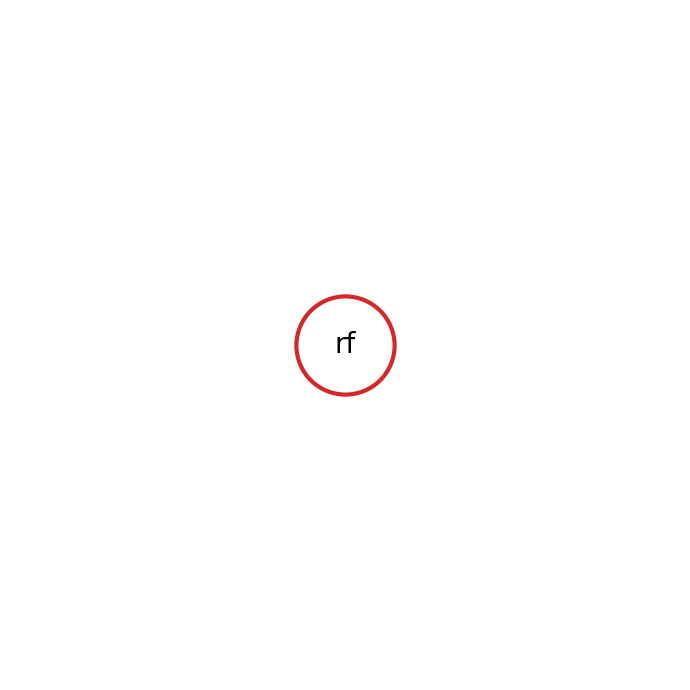

2023-06-09 17:04:13,967 - Predicting with statistical generator
2023-06-09 17:04:14,034 - Predicting with statistical generator
['no_anomaly' 'no_anomaly' 'decrease_dispersion' 'no_anomaly' 'dip' 'dip']
['dip', 'no_anomaly', 'no_anomaly', 'no_anomaly', 'dip', 'decrease_dispersion']
                     precision    recall  f1-score   support

decrease_dispersion       0.00      0.00      0.00         1
                dip       0.50      0.50      0.50         2
         no_anomaly       0.67      0.67      0.67         3

           accuracy                           0.50         6
          macro avg       0.39      0.39      0.39         6
       weighted avg       0.50      0.50      0.50         6



In [91]:
model.current_pipeline.show(node_size_scale=1)
labels_real = industrial_real.predict(test_features=test_data_real[0],
                            test_target=test_data_real[1])

probs_real = industrial_real.predict_proba(test_features=test_data_real[0],
                                 test_target=test_data_real[1])

print(labels_real.ravel()), print(test_data_real[1])

print(classification_report(test_data_real[1], labels_real))